In [1]:
# Load packages

# General math packages
import numpy as np
from scipy.integrate import odeint
import math

# Visualization
import matplotlib.pyplot as plt

# Data Science
import tensorflow as tf

import pickle

## Create model for pendulum behaviour + generate data

In [2]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Function that returns dtheta/dt.
def model(theta, t, bm, l):
    g = 9.81
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1)
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt


In [3]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Inputs
b = 0
l = 1
m = 1
bm = b/m
actual_params = [b/m, l]
actual_theta_0 = [math.pi/2, 0]
t_min = 0
t_max = 5
t_step = 0.05
t = np.arange(t_min, t_max + t_step, t_step)

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

In [8]:
# Generate noise
noise_sd = 0
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

In [9]:
# Generate training dataset

# Adjusting the time range
t_max_new = 1.5  # Set the maximum time to 0.75 seconds
t_train = np.arange(t_min, t_max_new + t_step, t_step)

# Finding the index corresponding to the first second
index_train = int(t_max_new / t_step) + 1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_train = actual_theta[:index_train]

## Phisics Informed Neural Network (predict parameters)

In [6]:
# Define a custom sine activation function
def sin_activation(x):
    return tf.sin(x)

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.out = tf.keras.layers.Dense(2)  # Output: [theta1]
        # Define bm as a trainable parameter
        self.bm = tf.Variable(initial_value=0.1, trainable=True, dtype=tf.float32)
        self.beta_3 = tf.Variable(initial_value=0.1, trainable=True, dtype=tf.float32)
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta


In [7]:
# Define the loss function
def loss_fn(pinn, t_train_tensor, t_tensor, actual_theta_noisy_train_tensor, l):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        tape1.watch(t_tensor)
        tape2.watch(t_tensor)
        
        theta_pred = pinn(t_tensor)
        theta1_pred = theta_pred[:, 0]
        theta2_pred = theta_pred[:, 1]

        # Use the single value of bm and beta_3
        bm = pinn.bm
        beta_3 = pinn.beta_3

        # Compute derivatives
        # Compute the first derivatives for each component
        dtheta1_dt_pred = tape1.gradient(theta1_pred, t_tensor)
        dtheta1_dt_pred = tf.squeeze(dtheta1_dt_pred)

        dtheta2_dt_pred = tape2.gradient(theta2_pred, t_tensor)
        dtheta2_dt_pred = tf.squeeze(dtheta2_dt_pred)

        # Data loss: Mean Squared Error between predicted and noisy data
        theta_pred = pinn(t_train_tensor)
        data_loss = tf.reduce_mean(tf.square(theta_pred[:, 0] - actual_theta_noisy_train_tensor[:, 0]))

        # Physics loss: Based on the differential equations
        g = 9.81
        dtheta1_dt_equation = theta2_pred # 1st equation
        dtheta2_dt_equation = -(bm) * dtheta1_dt_equation - (g / l) * tf.sin(theta1_pred) + beta_3 * theta1_pred # 2nd equation
        
        physics_loss_1 = tf.reduce_mean(tf.square(dtheta1_dt_pred - dtheta1_dt_equation))
        physics_loss_2 = tf.reduce_mean(tf.square(dtheta2_dt_pred - dtheta2_dt_equation))

        total_loss = data_loss + 50*physics_loss_1 + 1*physics_loss_2
    return total_loss

Epoch 0, Loss: 50.43942642211914
Trained value of bm: -0.14067593216896057
Trained value of beta_3: 0.272838830947876


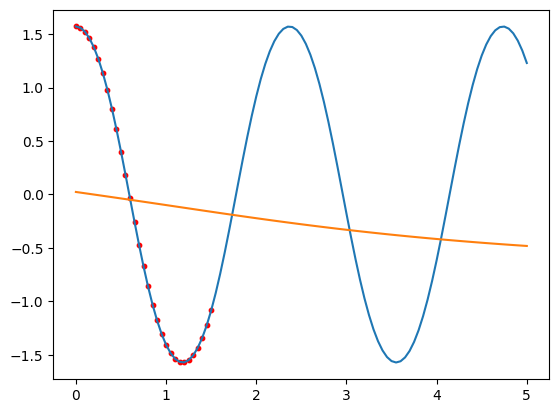

Epoch 1000, Loss: 1.407655119895935
Trained value of bm: -0.4940051734447479
Trained value of beta_3: 0.5914363265037537
Epoch 2000, Loss: 1.4020400047302246
Trained value of bm: -0.3228709101676941
Trained value of beta_3: 0.7705644369125366
Epoch 3000, Loss: 1.3932762145996094
Trained value of bm: -0.0737142562866211
Trained value of beta_3: 1.0089787244796753
Epoch 4000, Loss: 1.2633404731750488
Trained value of bm: 0.4920150935649872
Trained value of beta_3: 1.4511977434158325
Epoch 5000, Loss: 0.7120739817619324
Trained value of bm: 1.823914647102356
Trained value of beta_3: 2.684405565261841


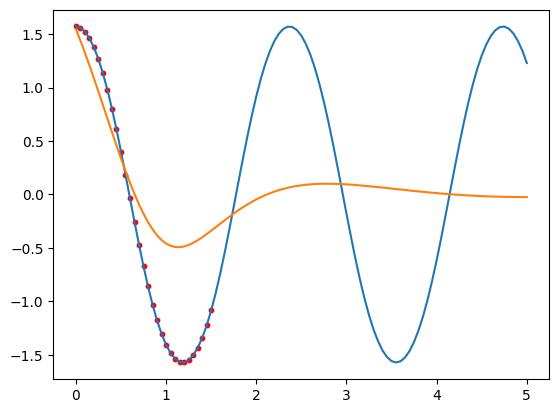

Epoch 6000, Loss: 0.3368173837661743
Trained value of bm: 1.2082160711288452
Trained value of beta_3: 3.631082773208618
Epoch 7000, Loss: 0.20211686193943024
Trained value of bm: 0.7982093095779419
Trained value of beta_3: 4.447652339935303
Epoch 8000, Loss: 0.11256865411996841
Trained value of bm: 0.7217440605163574
Trained value of beta_3: 4.58502197265625
Epoch 9000, Loss: 0.10869564861059189
Trained value of bm: 0.6960548162460327
Trained value of beta_3: 4.483418941497803
Epoch 10000, Loss: 0.04307204484939575
Trained value of bm: 0.6840512156486511
Trained value of beta_3: 4.326214790344238


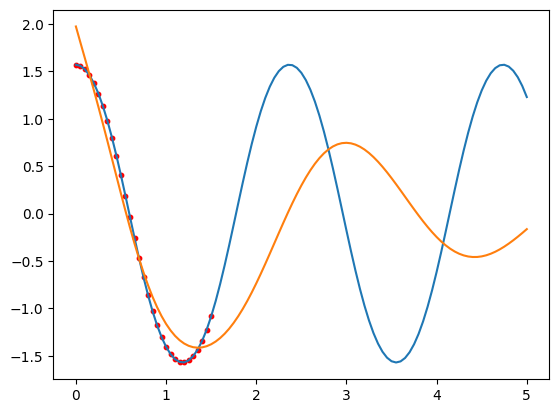

Epoch 11000, Loss: 0.035394757986068726
Trained value of bm: 0.6541593074798584
Trained value of beta_3: 4.193840026855469
Epoch 12000, Loss: 0.03361109271645546
Trained value of bm: 0.6256536245346069
Trained value of beta_3: 4.100336074829102
Epoch 13000, Loss: 0.03304123505949974
Trained value of bm: 0.6056877374649048
Trained value of beta_3: 4.0434980392456055
Epoch 14000, Loss: 0.03245823085308075
Trained value of bm: 0.5931375622749329
Trained value of beta_3: 4.008222579956055
Epoch 15000, Loss: 0.032144494354724884
Trained value of bm: 0.5844717621803284
Trained value of beta_3: 3.9847869873046875


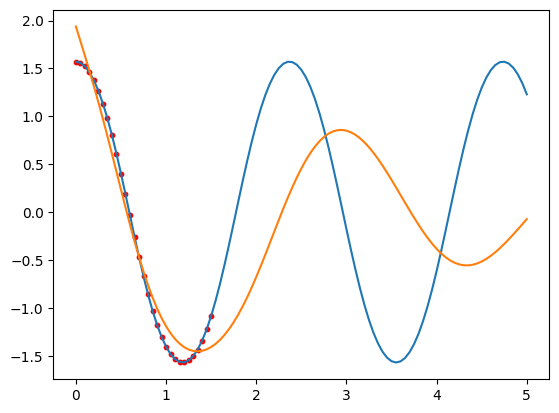

Epoch 16000, Loss: 0.0329875722527504
Trained value of bm: 0.5792747735977173
Trained value of beta_3: 3.966583013534546
Epoch 17000, Loss: 0.03182372450828552
Trained value of bm: 0.5754675269126892
Trained value of beta_3: 3.9464590549468994
Epoch 18000, Loss: 0.03144319728016853
Trained value of bm: 0.5728091597557068
Trained value of beta_3: 3.9247334003448486
Epoch 19000, Loss: 0.0326354093849659
Trained value of bm: 0.5725494623184204
Trained value of beta_3: 3.894083261489868
Epoch 20000, Loss: 0.03075942024588585
Trained value of bm: 0.5725128054618835
Trained value of beta_3: 3.855524778366089


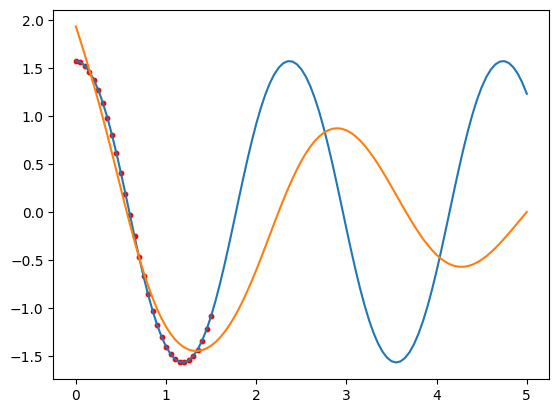

Epoch 21000, Loss: 0.03330574557185173
Trained value of bm: 0.5733565092086792
Trained value of beta_3: 3.8028645515441895
Epoch 22000, Loss: 0.029498077929019928
Trained value of bm: 0.5732808113098145
Trained value of beta_3: 3.719285011291504
Epoch 23000, Loss: 0.032577551901340485
Trained value of bm: 0.5676366090774536
Trained value of beta_3: 3.6058809757232666
Epoch 24000, Loss: 0.025188332423567772
Trained value of bm: 0.5533013939857483
Trained value of beta_3: 3.4711344242095947
Epoch 25000, Loss: 0.03130892664194107
Trained value of bm: 0.52983558177948
Trained value of beta_3: 3.3336875438690186


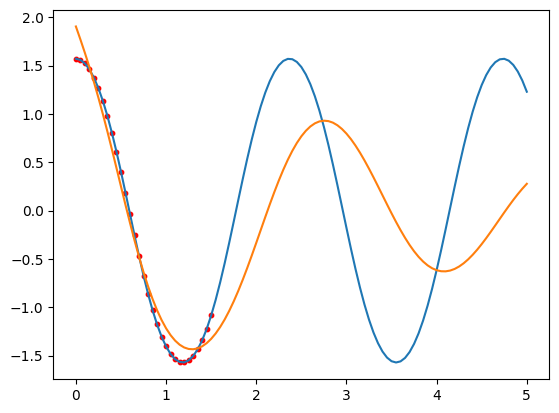

Epoch 26000, Loss: 0.03806448355317116
Trained value of bm: 0.5052381753921509
Trained value of beta_3: 3.2101049423217773
Epoch 27000, Loss: 0.0394761860370636
Trained value of bm: 0.48136839270591736
Trained value of beta_3: 3.106358289718628
Epoch 28000, Loss: 0.025914784520864487
Trained value of bm: 0.4616934061050415
Trained value of beta_3: 3.022233724594116
Epoch 29000, Loss: 0.0187450610101223
Trained value of bm: 0.44612157344818115
Trained value of beta_3: 2.9450297355651855
Epoch 30000, Loss: 0.018058281391859055
Trained value of bm: 0.43264299631118774
Trained value of beta_3: 2.873494863510132


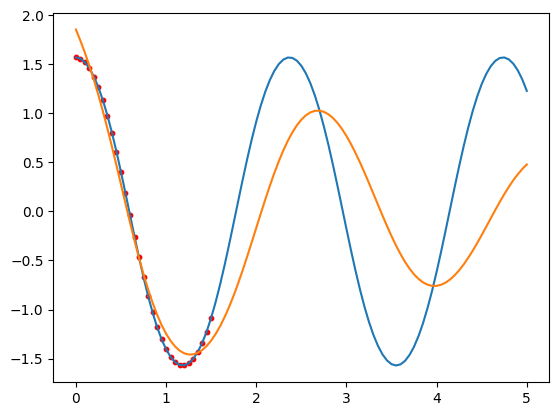

Epoch 31000, Loss: 0.017251405864953995
Trained value of bm: 0.42107558250427246
Trained value of beta_3: 2.804734468460083
Epoch 32000, Loss: 0.04059002920985222
Trained value of bm: 0.41008684039115906
Trained value of beta_3: 2.7348792552948
Epoch 33000, Loss: 0.01697799190878868
Trained value of bm: 0.3995584547519684
Trained value of beta_3: 2.6638717651367188
Epoch 34000, Loss: 0.015800075605511665
Trained value of bm: 0.3898787796497345
Trained value of beta_3: 2.5898733139038086
Epoch 35000, Loss: 0.014054466970264912
Trained value of bm: 0.3817777633666992
Trained value of beta_3: 2.515669345855713


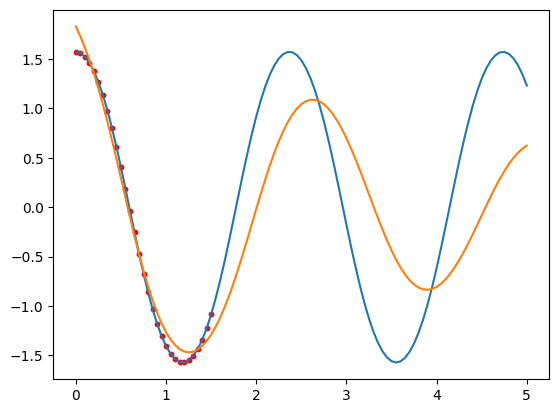

Epoch 36000, Loss: 0.013804945163428783
Trained value of bm: 0.3707297146320343
Trained value of beta_3: 2.442995309829712
Epoch 37000, Loss: 0.015759380534291267
Trained value of bm: 0.3609664738178253
Trained value of beta_3: 2.368356943130493
Epoch 38000, Loss: 0.011775444261729717
Trained value of bm: 0.35115694999694824
Trained value of beta_3: 2.297074317932129
Epoch 39000, Loss: 0.011044805869460106
Trained value of bm: 0.34179720282554626
Trained value of beta_3: 2.2266809940338135
Epoch 40000, Loss: 0.011127914302051067
Trained value of bm: 0.33235833048820496
Trained value of beta_3: 2.1540367603302


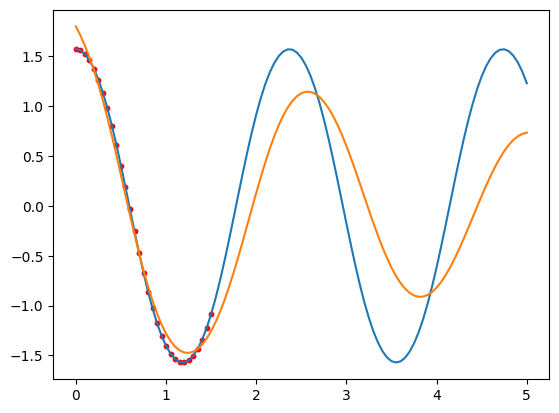

Epoch 41000, Loss: 0.009821783751249313
Trained value of bm: 0.32537516951560974
Trained value of beta_3: 2.0802459716796875
Epoch 42000, Loss: 0.00948740728199482
Trained value of bm: 0.31762784719467163
Trained value of beta_3: 2.003024101257324
Epoch 43000, Loss: 0.008556686341762543
Trained value of bm: 0.30964213609695435
Trained value of beta_3: 1.923061728477478
Epoch 44000, Loss: 0.03422515094280243
Trained value of bm: 0.30295491218566895
Trained value of beta_3: 1.8415664434432983
Epoch 45000, Loss: 0.007528054062277079
Trained value of bm: 0.28977566957473755
Trained value of beta_3: 1.7605340480804443


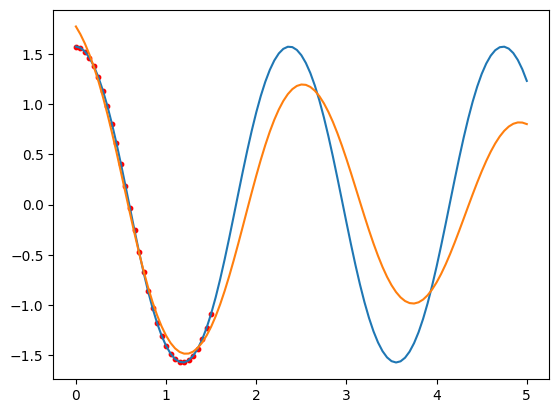

Epoch 46000, Loss: 0.009434516541659832
Trained value of bm: 0.27717500925064087
Trained value of beta_3: 1.6814316511154175
Epoch 47000, Loss: 0.010358434170484543
Trained value of bm: 0.26849988102912903
Trained value of beta_3: 1.6065443754196167
Epoch 48000, Loss: 0.006483233999460936
Trained value of bm: 0.25587373971939087
Trained value of beta_3: 1.535186767578125
Epoch 49000, Loss: 0.012836121954023838
Trained value of bm: 0.24651190638542175
Trained value of beta_3: 1.4691728353500366
Epoch 50000, Loss: 0.004844911862164736
Trained value of bm: 0.2349359691143036
Trained value of beta_3: 1.4088953733444214


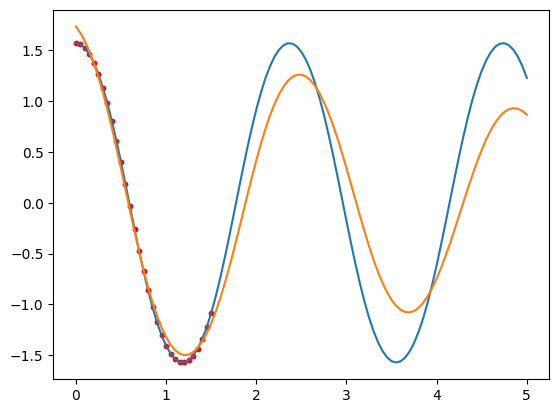

Epoch 51000, Loss: 0.014111644588410854
Trained value of bm: 0.22571933269500732
Trained value of beta_3: 1.3517262935638428
Epoch 52000, Loss: 0.004152167588472366
Trained value of bm: 0.2148001492023468
Trained value of beta_3: 1.3004359006881714
Epoch 53000, Loss: 0.005810889881104231
Trained value of bm: 0.20454633235931396
Trained value of beta_3: 1.2518504858016968
Epoch 54000, Loss: 0.006418293807655573
Trained value of bm: 0.19759917259216309
Trained value of beta_3: 1.2075351476669312
Epoch 55000, Loss: 0.006011578720062971
Trained value of bm: 0.18758389353752136
Trained value of beta_3: 1.166198492050171


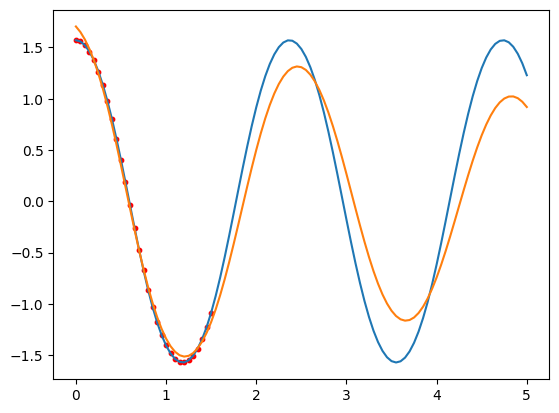

Epoch 56000, Loss: 0.003351322142407298
Trained value of bm: 0.18200993537902832
Trained value of beta_3: 1.127518892288208
Epoch 57000, Loss: 0.0092307198792696
Trained value of bm: 0.17561359703540802
Trained value of beta_3: 1.0922271013259888
Epoch 58000, Loss: 0.004083084408193827
Trained value of bm: 0.17014674842357635
Trained value of beta_3: 1.059127688407898
Epoch 59000, Loss: 0.012571454048156738
Trained value of bm: 0.16530868411064148
Trained value of beta_3: 1.027245044708252
Epoch 60000, Loss: 0.002544028451666236
Trained value of bm: 0.159354105591774
Trained value of beta_3: 0.9970589876174927


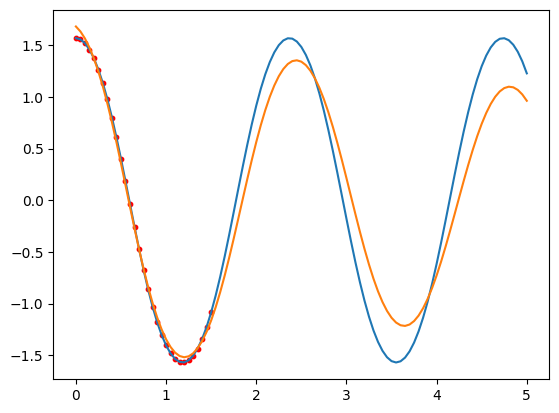

Epoch 61000, Loss: 0.0035969361197203398
Trained value of bm: 0.15579968690872192
Trained value of beta_3: 0.969428539276123
Epoch 62000, Loss: 0.0023412033915519714
Trained value of bm: 0.15039567649364471
Trained value of beta_3: 0.9439168572425842
Epoch 63000, Loss: 0.008142400532960892
Trained value of bm: 0.14605164527893066
Trained value of beta_3: 0.9171227216720581
Epoch 64000, Loss: 0.0029079143423587084
Trained value of bm: 0.14288929104804993
Trained value of beta_3: 0.8932997584342957
Epoch 65000, Loss: 0.002963633742183447
Trained value of bm: 0.13958171010017395
Trained value of beta_3: 0.8700286149978638


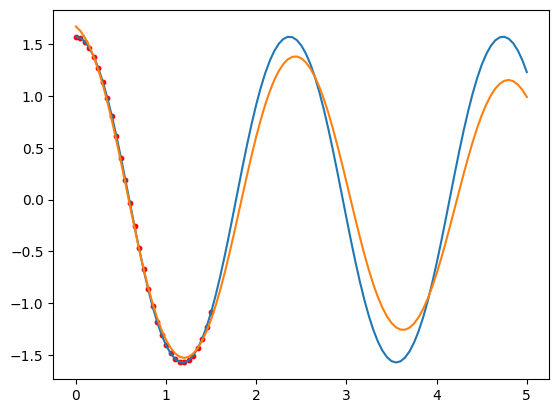

Epoch 66000, Loss: 0.0023643430322408676
Trained value of bm: 0.13569925725460052
Trained value of beta_3: 0.8482936024665833
Epoch 67000, Loss: 0.0019056143937632442
Trained value of bm: 0.13168686628341675
Trained value of beta_3: 0.8273406028747559
Epoch 68000, Loss: 0.018724270164966583
Trained value of bm: 0.1249878853559494
Trained value of beta_3: 0.8076127767562866
Epoch 69000, Loss: 0.003907314036041498
Trained value of bm: 0.12588335573673248
Trained value of beta_3: 0.7889124751091003
Epoch 70000, Loss: 0.0016701256390661001
Trained value of bm: 0.12200866639614105
Trained value of beta_3: 0.7696791291236877


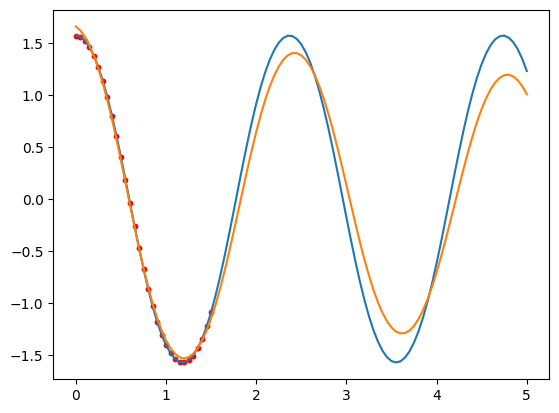

Epoch 71000, Loss: 0.0029367716051638126
Trained value of bm: 0.11830174922943115
Trained value of beta_3: 0.7524082660675049
Epoch 72000, Loss: 0.001880516647361219
Trained value of bm: 0.11672167479991913
Trained value of beta_3: 0.7347045540809631
Epoch 73000, Loss: 0.0030497817788273096
Trained value of bm: 0.11349334567785263
Trained value of beta_3: 0.7190219759941101
Epoch 74000, Loss: 0.0018384172581136227
Trained value of bm: 0.11040522903203964
Trained value of beta_3: 0.7031273245811462
Epoch 75000, Loss: 0.001524394261650741
Trained value of bm: 0.10877209901809692
Trained value of beta_3: 0.6876587271690369


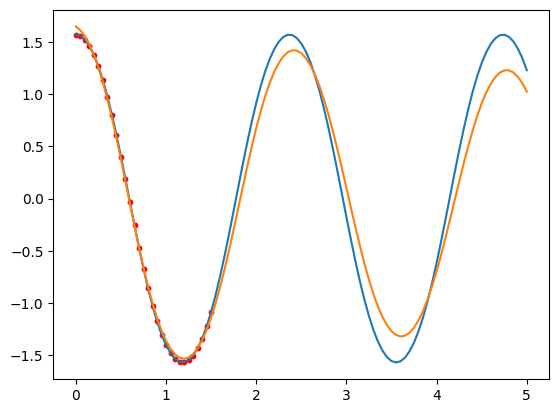

Epoch 76000, Loss: 0.001410587108694017
Trained value of bm: 0.10587752610445023
Trained value of beta_3: 0.6736121773719788
Epoch 77000, Loss: 0.01712908037006855
Trained value of bm: 0.10483033955097198
Trained value of beta_3: 0.6595383286476135
Epoch 78000, Loss: 0.001199387013912201
Trained value of bm: 0.1010647565126419
Trained value of beta_3: 0.6459221839904785
Epoch 79000, Loss: 0.01839372329413891
Trained value of bm: 0.10220829397439957
Trained value of beta_3: 0.6328505873680115
Epoch 80000, Loss: 0.0037481640465557575
Trained value of bm: 0.09525337815284729
Trained value of beta_3: 0.6206254959106445


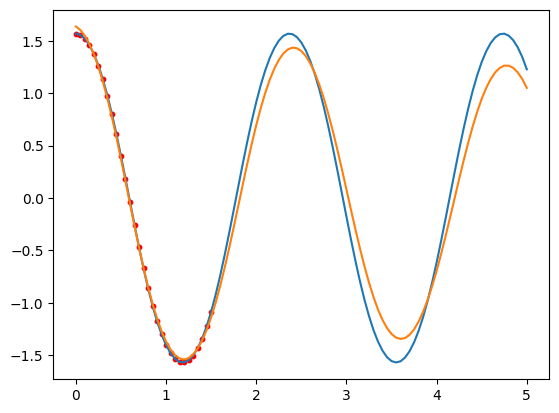

Epoch 81000, Loss: 0.004557338543236256
Trained value of bm: 0.09552118927240372
Trained value of beta_3: 0.6083074808120728
Epoch 82000, Loss: 0.00929426308721304
Trained value of bm: 0.0901738703250885
Trained value of beta_3: 0.5968610644340515
Epoch 83000, Loss: 0.004612940829247236
Trained value of bm: 0.09025733172893524
Trained value of beta_3: 0.5846327543258667
Epoch 84000, Loss: 0.0010202558478340507
Trained value of bm: 0.0881824865937233
Trained value of beta_3: 0.5740624666213989
Epoch 85000, Loss: 0.0009010556386783719
Trained value of bm: 0.08574402332305908
Trained value of beta_3: 0.5635625720024109


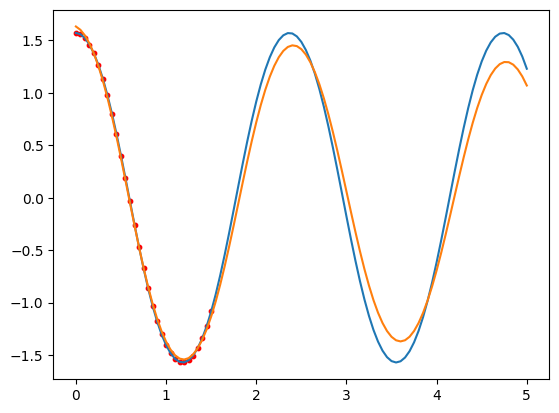

Epoch 86000, Loss: 0.001225389656610787
Trained value of bm: 0.08399736881256104
Trained value of beta_3: 0.5534144043922424
Epoch 87000, Loss: 0.003880722913891077
Trained value of bm: 0.08325576782226562
Trained value of beta_3: 0.5432437658309937
Epoch 88000, Loss: 0.0012357693631201982
Trained value of bm: 0.07980193197727203
Trained value of beta_3: 0.5334508419036865
Epoch 89000, Loss: 0.008351230062544346
Trained value of bm: 0.0756242573261261
Trained value of beta_3: 0.5232290029525757
Epoch 90000, Loss: 0.002927949884906411
Trained value of bm: 0.07534381002187729
Trained value of beta_3: 0.5140445828437805


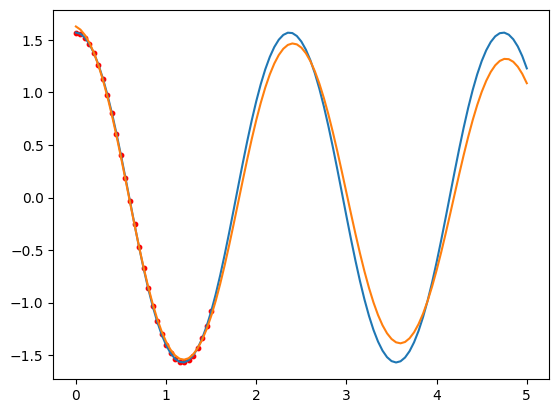

Epoch 91000, Loss: 0.003209242597222328
Trained value of bm: 0.07518098503351212
Trained value of beta_3: 0.5045186877250671
Epoch 92000, Loss: 0.0007567838183604181
Trained value of bm: 0.07287371903657913
Trained value of beta_3: 0.49573132395744324
Epoch 93000, Loss: 0.0008366803522221744
Trained value of bm: 0.07179870456457138
Trained value of beta_3: 0.48656165599823
Epoch 94000, Loss: 0.0013365003978833556
Trained value of bm: 0.0701851025223732
Trained value of beta_3: 0.47761476039886475
Epoch 95000, Loss: 0.004345918074250221
Trained value of bm: 0.06829849630594254
Trained value of beta_3: 0.46865999698638916


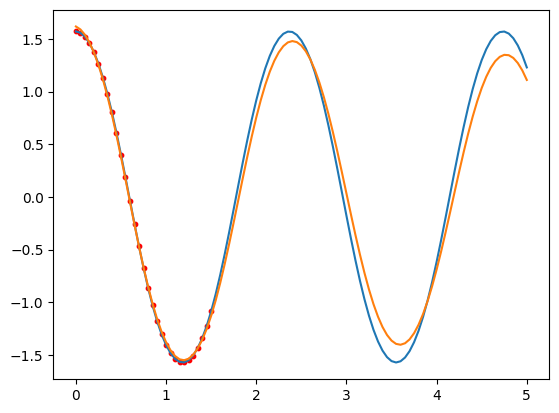

Epoch 96000, Loss: 0.003427924122661352
Trained value of bm: 0.06763190776109695
Trained value of beta_3: 0.4599283039569855
Epoch 97000, Loss: 0.0012788836611434817
Trained value of bm: 0.06575551629066467
Trained value of beta_3: 0.4511367976665497
Epoch 98000, Loss: 0.0029395821038633585
Trained value of bm: 0.06414249539375305
Trained value of beta_3: 0.4425106644630432
Epoch 99000, Loss: 0.0015715807676315308
Trained value of bm: 0.062473829835653305
Trained value of beta_3: 0.4341726303100586
Epoch 100000, Loss: 0.0049571264535188675
Trained value of bm: 0.06040382757782936
Trained value of beta_3: 0.42525941133499146


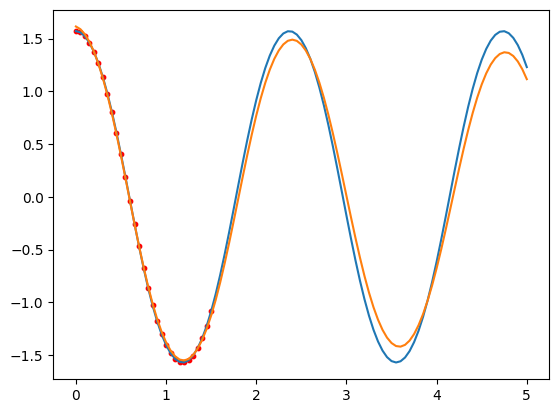

Epoch 101000, Loss: 0.014404933899641037
Trained value of bm: 0.06419194489717484
Trained value of beta_3: 0.41756319999694824
Epoch 102000, Loss: 0.0006428745691664517
Trained value of bm: 0.05948106572031975
Trained value of beta_3: 0.4095308780670166
Epoch 103000, Loss: 0.0020435682963579893
Trained value of bm: 0.05708768218755722
Trained value of beta_3: 0.400836706161499
Epoch 104000, Loss: 0.0021518697030842304
Trained value of bm: 0.058854978531599045
Trained value of beta_3: 0.39284563064575195
Epoch 105000, Loss: 0.0014371444704011083
Trained value of bm: 0.05698632821440697
Trained value of beta_3: 0.3854570686817169


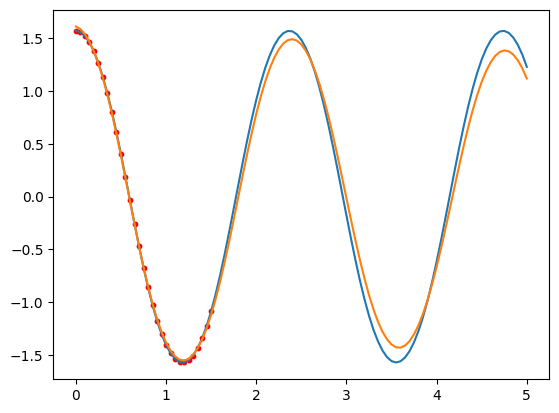

Epoch 106000, Loss: 0.0010174053022637963
Trained value of bm: 0.05551861971616745
Trained value of beta_3: 0.3776237964630127
Epoch 107000, Loss: 0.0019400690216571093
Trained value of bm: 0.05437963828444481
Trained value of beta_3: 0.36947229504585266
Epoch 108000, Loss: 0.006252241786569357
Trained value of bm: 0.05210694670677185
Trained value of beta_3: 0.3620592951774597
Epoch 109000, Loss: 0.009097389876842499
Trained value of bm: 0.05477594584226608
Trained value of beta_3: 0.35430535674095154
Epoch 110000, Loss: 0.000524223898537457
Trained value of bm: 0.05221433565020561
Trained value of beta_3: 0.3477899432182312


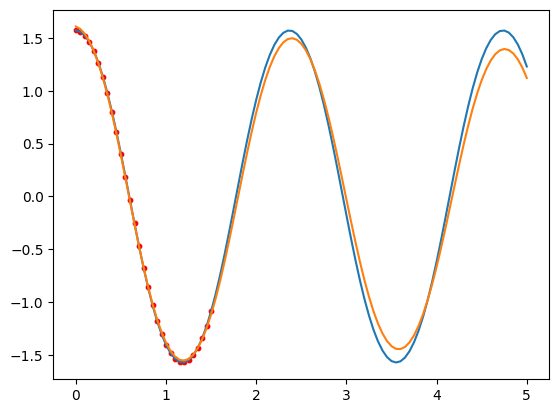

Epoch 111000, Loss: 0.003846700768917799
Trained value of bm: 0.051304977387189865
Trained value of beta_3: 0.33990439772605896
Epoch 112000, Loss: 0.0004944872343912721
Trained value of bm: 0.050781335681676865
Trained value of beta_3: 0.3323492109775543
Epoch 113000, Loss: 0.005967949517071247
Trained value of bm: 0.04755190387368202
Trained value of beta_3: 0.3252871036529541
Epoch 114000, Loss: 0.0005315140588209033
Trained value of bm: 0.04942551255226135
Trained value of beta_3: 0.31872376799583435
Epoch 115000, Loss: 0.0017029757145792246
Trained value of bm: 0.04860193282365799
Trained value of beta_3: 0.3118135333061218


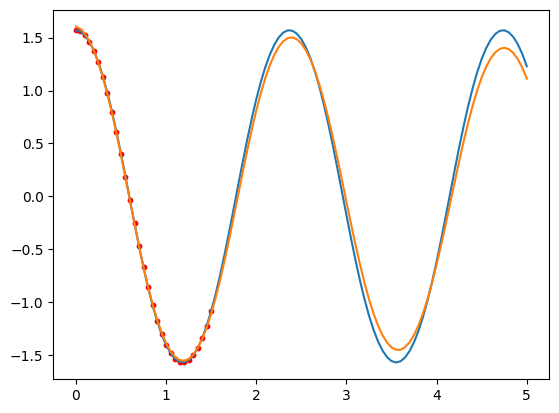

Epoch 116000, Loss: 0.004806669428944588
Trained value of bm: 0.04754142835736275
Trained value of beta_3: 0.30518215894699097
Epoch 117000, Loss: 0.02056112326681614
Trained value of bm: 0.05246485024690628
Trained value of beta_3: 0.29878246784210205
Epoch 118000, Loss: 0.007431565783917904
Trained value of bm: 0.04865878447890282
Trained value of beta_3: 0.2928454577922821
Epoch 119000, Loss: 0.0009511414682492614
Trained value of bm: 0.04645587131381035
Trained value of beta_3: 0.28703567385673523
Epoch 120000, Loss: 0.0012618331238627434
Trained value of bm: 0.045764658600091934
Trained value of beta_3: 0.2811044156551361


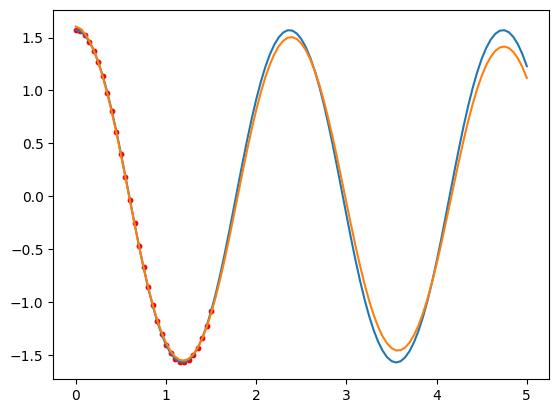

Epoch 121000, Loss: 0.00038676770054735243
Trained value of bm: 0.04496841877698898
Trained value of beta_3: 0.27504315972328186
Epoch 122000, Loss: 0.002364323241636157
Trained value of bm: 0.044835951179265976
Trained value of beta_3: 0.26994866132736206
Epoch 123000, Loss: 0.0018690464785322547
Trained value of bm: 0.04381127655506134
Trained value of beta_3: 0.2645576298236847
Epoch 124000, Loss: 0.0005437912186607718
Trained value of bm: 0.04312346875667572
Trained value of beta_3: 0.2595902383327484
Epoch 125000, Loss: 0.011934764683246613
Trained value of bm: 0.046447694301605225
Trained value of beta_3: 0.2545611560344696


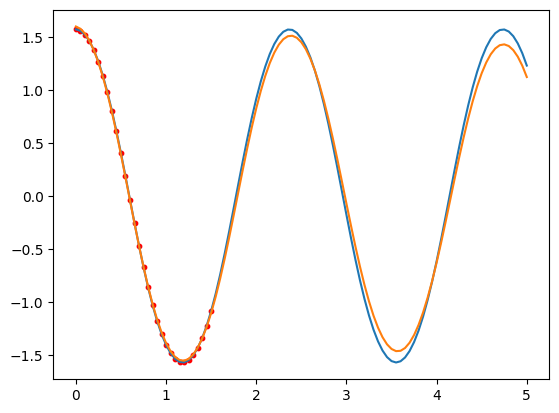

Epoch 126000, Loss: 0.0007320956792682409
Trained value of bm: 0.04290620610117912
Trained value of beta_3: 0.24998582899570465
Epoch 127000, Loss: 0.00040200489456765354
Trained value of bm: 0.04121870920062065
Trained value of beta_3: 0.24523639678955078
Epoch 128000, Loss: 0.0032278113067150116
Trained value of bm: 0.04261009022593498
Trained value of beta_3: 0.2408495545387268
Epoch 129000, Loss: 0.0009311813628301024
Trained value of bm: 0.0397997684776783
Trained value of beta_3: 0.23683808743953705
Epoch 130000, Loss: 0.0009680220973677933
Trained value of bm: 0.04083988443017006
Trained value of beta_3: 0.23321875929832458


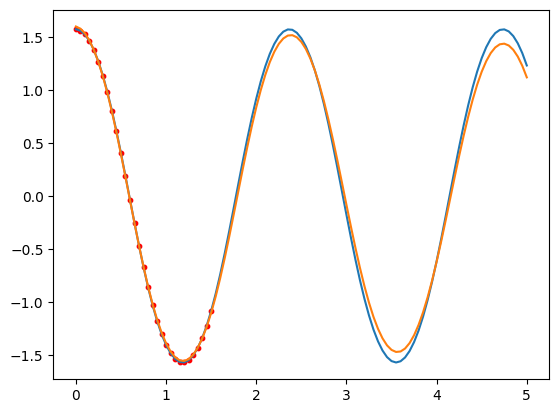

Epoch 131000, Loss: 0.010241787880659103
Trained value of bm: 0.04313891381025314
Trained value of beta_3: 0.22907693684101105
Epoch 132000, Loss: 0.00018987484509125352
Trained value of bm: 0.03916226699948311
Trained value of beta_3: 0.22517088055610657
Epoch 133000, Loss: 0.00036576774436980486
Trained value of bm: 0.03874240443110466
Trained value of beta_3: 0.22207841277122498
Epoch 134000, Loss: 0.00020734698045998812
Trained value of bm: 0.03845485299825668
Trained value of beta_3: 0.21842889487743378
Epoch 135000, Loss: 0.0004338094440754503
Trained value of bm: 0.038165148347616196
Trained value of beta_3: 0.21501606702804565


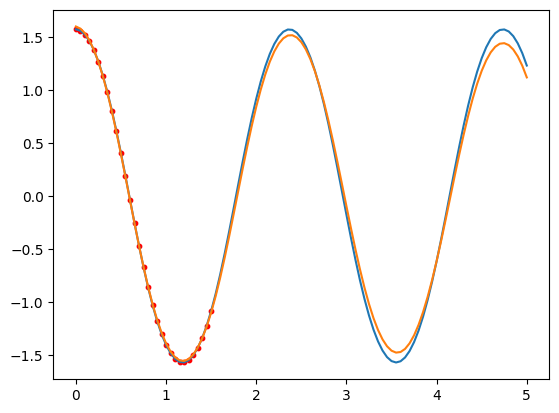

Epoch 136000, Loss: 0.0007989864097908139
Trained value of bm: 0.03780873119831085
Trained value of beta_3: 0.21266257762908936
Epoch 137000, Loss: 0.001786528155207634
Trained value of bm: 0.03752296790480614
Trained value of beta_3: 0.20945625007152557
Epoch 138000, Loss: 0.004855407401919365
Trained value of bm: 0.03765174746513367
Trained value of beta_3: 0.20633022487163544
Epoch 139000, Loss: 0.00036965287290513515
Trained value of bm: 0.036021776497364044
Trained value of beta_3: 0.2033899575471878
Epoch 140000, Loss: 0.0005009241867810488
Trained value of bm: 0.0357983261346817
Trained value of beta_3: 0.20089936256408691


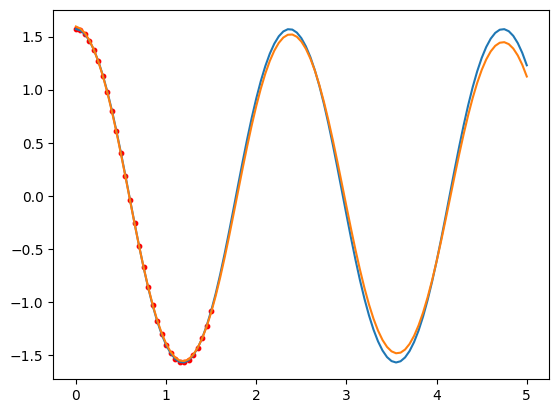

Epoch 141000, Loss: 0.008912657387554646
Trained value of bm: 0.03253895416855812
Trained value of beta_3: 0.19822582602500916
Epoch 142000, Loss: 0.00034679376403801143
Trained value of bm: 0.03531090170145035
Trained value of beta_3: 0.19584551453590393
Epoch 143000, Loss: 0.003408079268410802
Trained value of bm: 0.033683113753795624
Trained value of beta_3: 0.19355212152004242
Epoch 144000, Loss: 0.0001715362595859915
Trained value of bm: 0.03438139706850052
Trained value of beta_3: 0.19104650616645813
Epoch 145000, Loss: 0.0001500406360719353
Trained value of bm: 0.03402459993958473
Trained value of beta_3: 0.18919040262699127


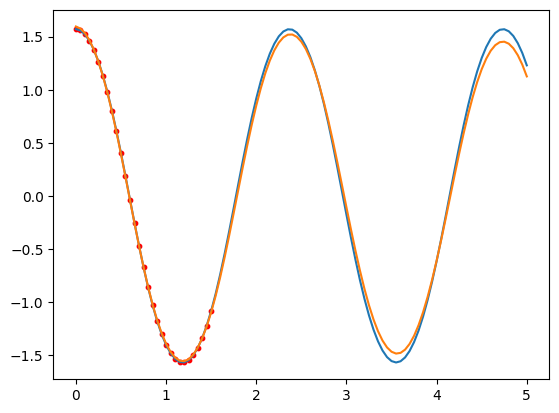

Epoch 146000, Loss: 0.0023104362189769745
Trained value of bm: 0.03359092026948929
Trained value of beta_3: 0.1872945874929428
Epoch 147000, Loss: 0.0037684431299567223
Trained value of bm: 0.03248041868209839
Trained value of beta_3: 0.18470357358455658
Epoch 148000, Loss: 0.0008549247868359089
Trained value of bm: 0.03251015767455101
Trained value of beta_3: 0.18296079337596893
Epoch 149000, Loss: 0.0001795282878447324
Trained value of bm: 0.03280673921108246
Trained value of beta_3: 0.1811554729938507
Epoch 150000, Loss: 0.0015541852917522192
Trained value of bm: 0.03198891505599022
Trained value of beta_3: 0.17960429191589355


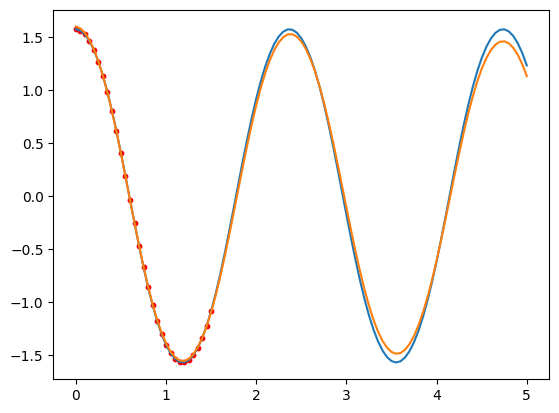

Epoch 151000, Loss: 0.0003999156760983169
Trained value of bm: 0.03266167268157005
Trained value of beta_3: 0.17806698381900787
Epoch 152000, Loss: 0.0005071190535090864
Trained value of bm: 0.031363390386104584
Trained value of beta_3: 0.17608949542045593
Epoch 153000, Loss: 0.0005687884986400604
Trained value of bm: 0.032401882112026215
Trained value of beta_3: 0.1746828258037567
Epoch 154000, Loss: 0.00017916571232490242
Trained value of bm: 0.03158162161707878
Trained value of beta_3: 0.17343322932720184
Epoch 155000, Loss: 0.001139613799750805
Trained value of bm: 0.03244208171963692
Trained value of beta_3: 0.1718367338180542


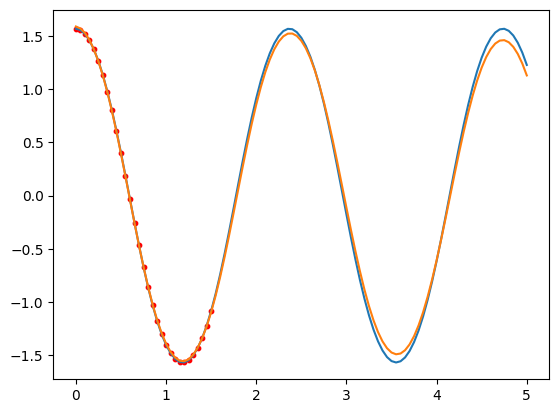

Epoch 156000, Loss: 0.0055295685306191444
Trained value of bm: 0.02858816087245941
Trained value of beta_3: 0.17031411826610565
Epoch 157000, Loss: 0.001175795216113329
Trained value of bm: 0.03151034936308861
Trained value of beta_3: 0.1692175567150116
Epoch 158000, Loss: 0.00024606555234640837
Trained value of bm: 0.030818480998277664
Trained value of beta_3: 0.1679960936307907
Epoch 159000, Loss: 0.0008973226067610085
Trained value of bm: 0.030349839478731155
Trained value of beta_3: 0.16648975014686584
Epoch 160000, Loss: 0.0021625047083944082
Trained value of bm: 0.03054145723581314
Trained value of beta_3: 0.16538318991661072


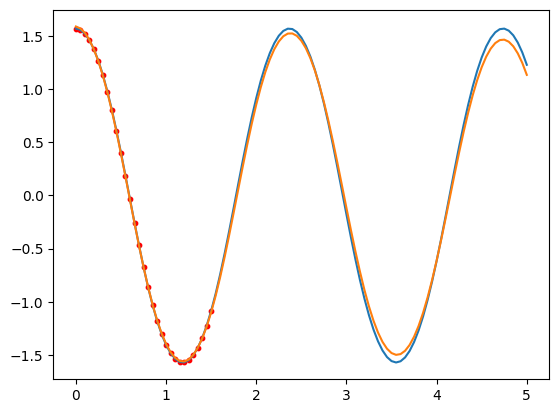

Epoch 161000, Loss: 0.009912610054016113
Trained value of bm: 0.032157834619283676
Trained value of beta_3: 0.16444315016269684
Epoch 162000, Loss: 0.0012565664947032928
Trained value of bm: 0.029454754665493965
Trained value of beta_3: 0.1634264588356018
Epoch 163000, Loss: 0.0029149027541279793
Trained value of bm: 0.027938518673181534
Trained value of beta_3: 0.16209180653095245
Epoch 164000, Loss: 0.0032143963035196066
Trained value of bm: 0.028844475746154785
Trained value of beta_3: 0.1615171730518341
Epoch 165000, Loss: 0.0012727401917800307
Trained value of bm: 0.028979448601603508
Trained value of beta_3: 0.1601380854845047


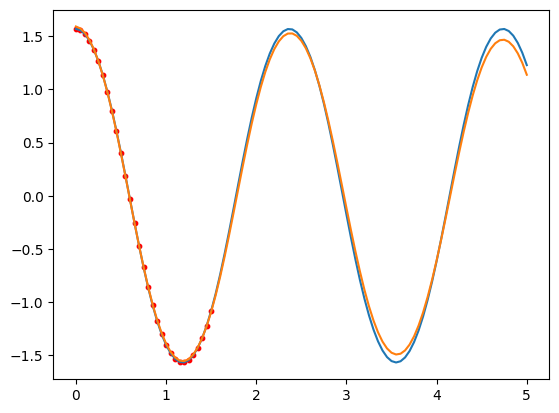

Epoch 166000, Loss: 0.003290134482085705
Trained value of bm: 0.026767760515213013
Trained value of beta_3: 0.1590976119041443
Epoch 167000, Loss: 0.0001377231237711385
Trained value of bm: 0.02896306850016117
Trained value of beta_3: 0.15836729109287262
Epoch 168000, Loss: 0.0009625491802580655
Trained value of bm: 0.027614451944828033
Trained value of beta_3: 0.157521054148674
Epoch 169000, Loss: 0.001173637923784554
Trained value of bm: 0.029099324718117714
Trained value of beta_3: 0.15673264861106873
Epoch 170000, Loss: 0.003073416417464614
Trained value of bm: 0.027434557676315308
Trained value of beta_3: 0.15576806664466858


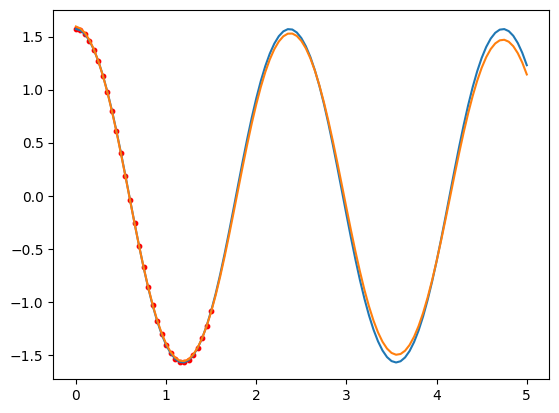

Epoch 171000, Loss: 0.00015979851013980806
Trained value of bm: 0.028255010023713112
Trained value of beta_3: 0.15488606691360474
Epoch 172000, Loss: 0.00014956272207200527
Trained value of bm: 0.028212586417794228
Trained value of beta_3: 0.15401972830295563
Epoch 173000, Loss: 0.004634564742445946
Trained value of bm: 0.02520785667002201
Trained value of beta_3: 0.15353181958198547
Epoch 174000, Loss: 0.0007083805976435542
Trained value of bm: 0.02755885384976864
Trained value of beta_3: 0.1527334749698639
Epoch 175000, Loss: 0.00012437965779099613
Trained value of bm: 0.027872035279870033
Trained value of beta_3: 0.1520187109708786


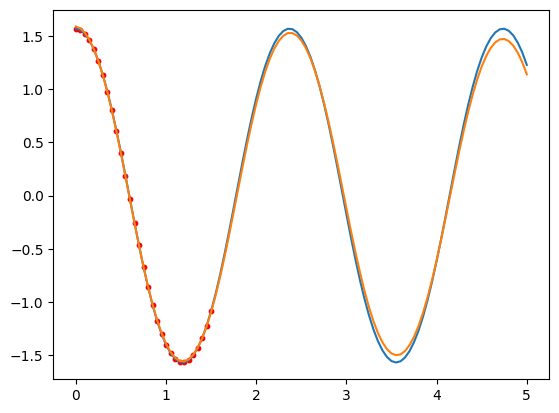

Epoch 176000, Loss: 0.0015154356369748712
Trained value of bm: 0.02676350064575672
Trained value of beta_3: 0.15112623572349548
Epoch 177000, Loss: 0.0009196664905175567
Trained value of bm: 0.027261056005954742
Trained value of beta_3: 0.15021862089633942
Epoch 178000, Loss: 0.0010665745940059423
Trained value of bm: 0.027178382501006126
Trained value of beta_3: 0.14982061088085175
Epoch 179000, Loss: 0.0039550443179905415
Trained value of bm: 0.029029957950115204
Trained value of beta_3: 0.1489255577325821
Epoch 180000, Loss: 0.0004556688363663852
Trained value of bm: 0.02709462121129036
Trained value of beta_3: 0.14813491702079773


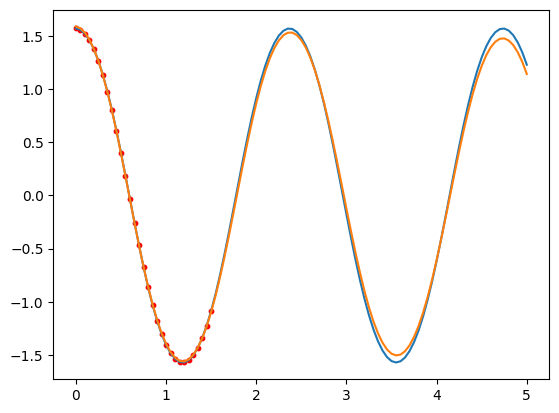

Epoch 181000, Loss: 0.00016595967463217676
Trained value of bm: 0.02686127834022045
Trained value of beta_3: 0.14750739932060242
Epoch 182000, Loss: 0.0002071753697237
Trained value of bm: 0.02664671652019024
Trained value of beta_3: 0.14721368253231049
Epoch 183000, Loss: 0.00022757767874281853
Trained value of bm: 0.026181049644947052
Trained value of beta_3: 0.14648659527301788
Epoch 184000, Loss: 0.0011914134956896305
Trained value of bm: 0.027346637099981308
Trained value of beta_3: 0.1455354541540146
Epoch 185000, Loss: 0.0004337142745498568
Trained value of bm: 0.025796478614211082
Trained value of beta_3: 0.14517851173877716


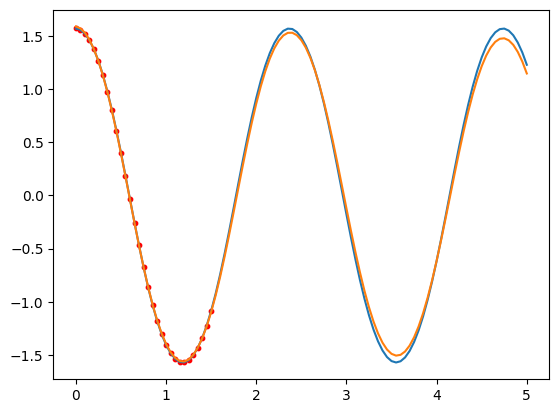

Epoch 186000, Loss: 8.154626993928105e-05
Trained value of bm: 0.026458818465471268
Trained value of beta_3: 0.14469385147094727
Epoch 187000, Loss: 0.00310025573708117
Trained value of bm: 0.025782406330108643
Trained value of beta_3: 0.14424347877502441
Epoch 188000, Loss: 0.00020821850921493024
Trained value of bm: 0.025923851877450943
Trained value of beta_3: 0.14359253644943237
Epoch 189000, Loss: 0.000471001083496958
Trained value of bm: 0.026041848585009575
Trained value of beta_3: 0.14308342337608337
Epoch 190000, Loss: 0.0020903332624584436
Trained value of bm: 0.025844233110547066
Trained value of beta_3: 0.1425776183605194


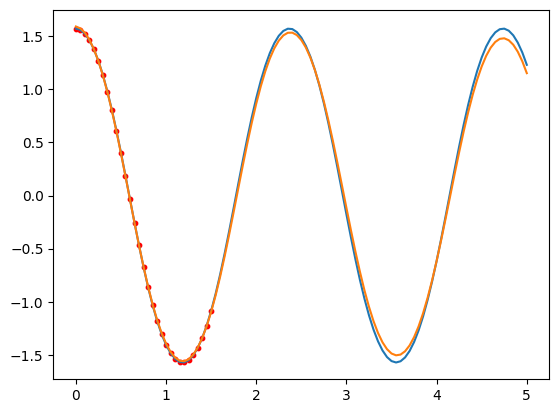

Epoch 191000, Loss: 0.0027158139273524284
Trained value of bm: 0.024113629013299942
Trained value of beta_3: 0.14178471267223358
Epoch 192000, Loss: 0.0005667878431268036
Trained value of bm: 0.025285353884100914
Trained value of beta_3: 0.14145129919052124
Epoch 193000, Loss: 0.0006062939064577222
Trained value of bm: 0.026077749207615852
Trained value of beta_3: 0.14089952409267426
Epoch 194000, Loss: 0.0011792662553489208
Trained value of bm: 0.02531077153980732
Trained value of beta_3: 0.14033830165863037
Epoch 195000, Loss: 0.0025420174933969975
Trained value of bm: 0.02513461373746395
Trained value of beta_3: 0.13996034860610962


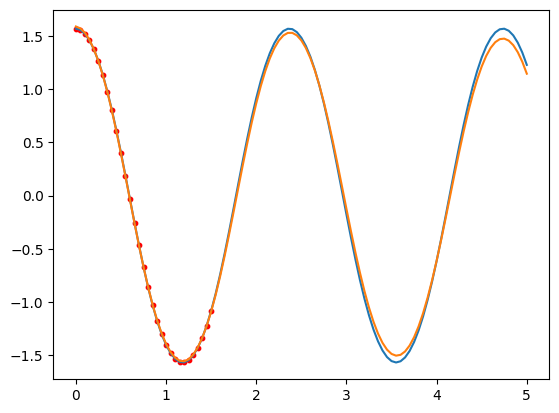

Epoch 196000, Loss: 0.003103397786617279
Trained value of bm: 0.025708628818392754
Trained value of beta_3: 0.13927416503429413
Epoch 197000, Loss: 9.989121463149786e-05
Trained value of bm: 0.025202199816703796
Trained value of beta_3: 0.13888494670391083
Epoch 198000, Loss: 0.007655644789338112
Trained value of bm: 0.0258041825145483
Trained value of beta_3: 0.13816922903060913
Epoch 199000, Loss: 0.0018673910526558757
Trained value of bm: 0.025027433410286903
Trained value of beta_3: 0.13770915567874908


In [8]:
# Initialize the neural network
pinn = PINN()

# Convert training data to tensorflow tensors
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
t_train_tensor = tf.reshape(t_train_tensor, (-1, 1))

t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))

actual_theta_noisy_train_tensor = tf.convert_to_tensor(actual_theta_noisy_train, dtype=tf.float32)

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Initialize a list to store MSE values
loss_values = []
bm_values = []
beta_3_values = []

# Training loop
num_epochs = 200000
freq_store_values = 1000
freq_plot = 5000

for epoch in range(num_epochs):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2, tf.GradientTape() as tape3:
        loss = loss_fn(pinn, t_train_tensor, t_tensor, actual_theta_noisy_train_tensor, actual_params[1])
    grads = tape1.gradient(loss, pinn.trainable_variables)
    bm_gradients = tape2.gradient(loss, pinn.bm)
    beta_3_gradients = tape3.gradient(loss, pinn.beta_3)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    pinn.bm.assign_sub(0.03 * bm_gradients)  # Adjust the learning rate as needed for bm
    pinn.beta_3.assign_sub(0.03 * beta_3_gradients)  # Adjust the learning rate as needed for beta_3
    
    if epoch % freq_store_values == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')
        loss_values.append(loss.numpy())
        print(f'Trained value of bm: {pinn.bm.numpy()}')
        bm_values.append(pinn.bm.numpy())
        print(f'Trained value of beta_3: {pinn.beta_3.numpy()}')
        beta_3_values.append(pinn.beta_3.numpy())

    if epoch % freq_plot == 0:
        theta_pred = pinn(t_tensor).numpy()
        plt.plot(t, actual_theta[:, 0], label='Actual θ1')
        plt.plot(t, theta_pred[:, 0], label='Predicted θ1')
        plt.scatter(t_train, actual_theta_noisy_train[:, 0], color='red', label='Noisy θ1', s=10)
        plt.show()


# After training, the model should be able to predict theta values that adhere to the differential equations

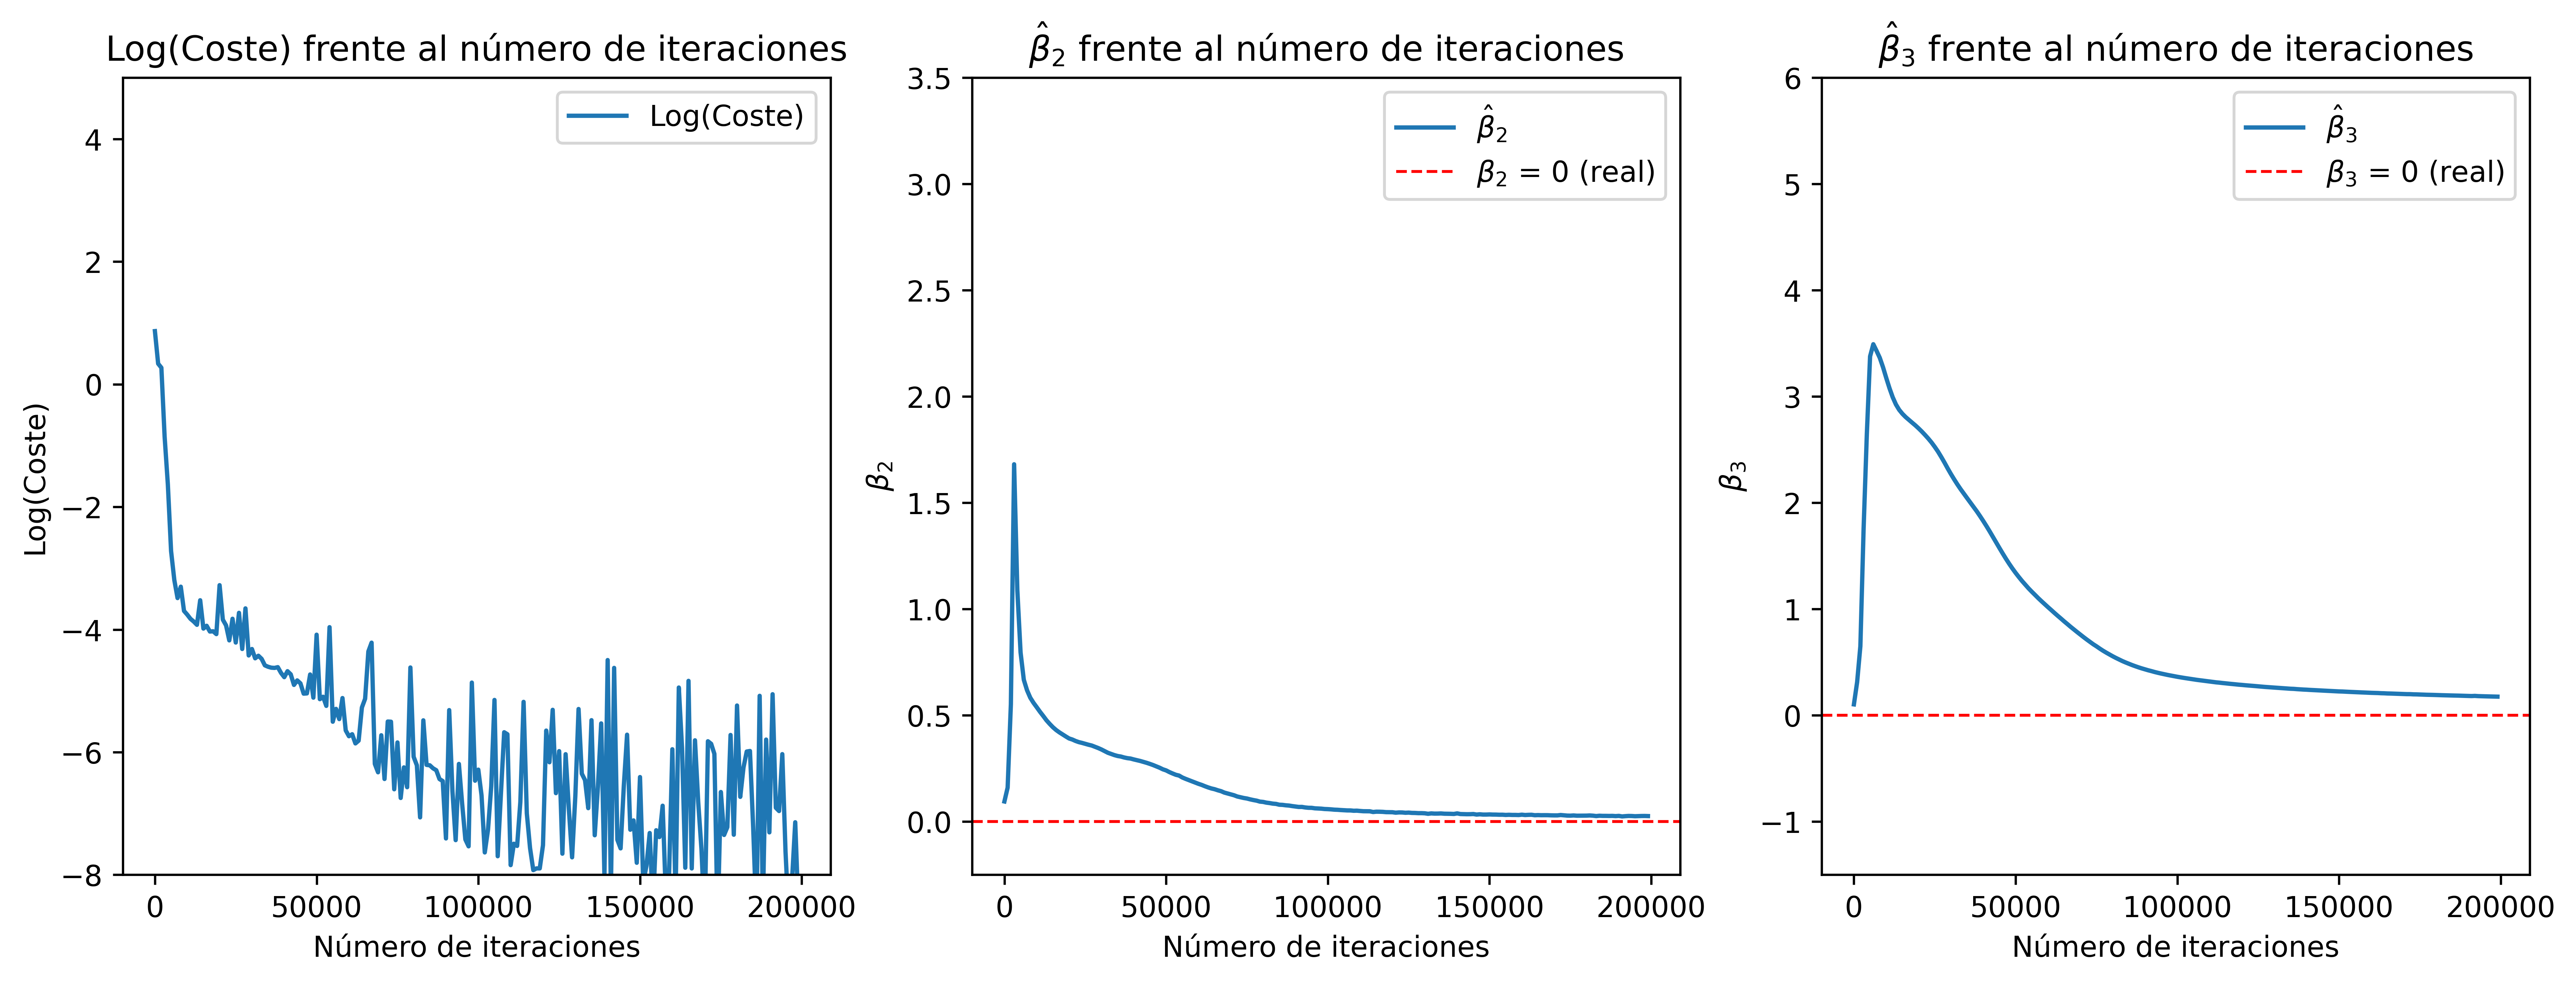

In [19]:
num_epochs = 200000
freq_store_values = 1000

# Plot the results
plt.figure(figsize=(15, 5), dpi=600)

# Plot the MSE values
plt.subplot(1, 3, 1)
plt.plot(range(0, num_epochs, freq_store_values), np.log(loss_values), label='Log(Coste)')
plt.ylim(-8, 5)
plt.xlabel('Número de iteraciones')
plt.ylabel('Log(Coste)')
plt.title('Log(Coste) frente al número de iteraciones')
plt.legend()

# Plot the MSE values
plt.subplot(1, 3, 2)
plt.plot(range(0, num_epochs, freq_store_values), bm_values, label=r'$\hat{\beta}_2$')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label=r'$\beta_2$ = 0 (real)')
plt.ylim(-0.25, 3.5)
plt.xlabel('Número de iteraciones')
plt.ylabel(r'$\beta_2$')
plt.title(r'$\hat{\beta}_2$ frente al número de iteraciones')
plt.legend()

# Plot the MSE values
plt.subplot(1, 3, 3)
plt.plot(range(0, num_epochs, freq_store_values), beta_3_values, label=r'$\hat{\beta}_3$')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label=r'$\beta_3$ = 0 (real)')
plt.ylim(-1.5, 6)
plt.xlabel('Número de iteraciones')
plt.ylabel(r'$\beta_3$')
plt.title(r'$\hat{\beta}_3$ frente al número de iteraciones')
plt.legend()

plt.show()

In [118]:
with open(r'discovery_pickles/discovery_loss_values_00_000_150s_noise30.pkl', 'wb') as fp:
    pickle.dump(loss_values, fp)

with open(r'discovery_pickles/discovery_bm_values_00_000_150s_noise30.pkl', 'wb') as fp:
    pickle.dump(bm_values, fp)

with open(r'discovery_pickles/discovery_beta_3_values_00_000_150s_noise30.pkl', 'wb') as fp:
    pickle.dump(beta_3_values, fp)

with open(r'discovery_pickles/discovery_pinn_pred_00_000_150s_noise30.pkl', 'wb') as fp:
    pickle.dump(pinn(t_tensor).numpy(), fp)

In [17]:
with open(r'discovery_pickles/discovery_loss_values_00_000_150s_noise00.pkl', 'rb') as fp:
    loss_values = pickle.load(fp)

with open(r'discovery_pickles/discovery_bm_values_00_000_150s_noise00.pkl', 'rb') as fp:
    bm_values = pickle.load(fp)

with open(r'discovery_pickles/discovery_beta_3_values_00_000_150s_noise00.pkl', 'rb') as fp:
    beta_3_values = pickle.load(fp)

with open(r'discovery_pickles/discovery_pinn_pred_00_000_150s_noise00.pkl', 'rb') as fp:
    pinn_pred = pickle.load(fp)

In [183]:
beta_3_values[-1]

-1.5393481

In [4]:
beta_2_pinn = []
beta_3_pinn = []
noises = ["00", "05", "10", "15", "20", "25", "30"]

for noise in noises:
    with open(f'discovery_pickles/discovery_bm_values_00_000_150s_noise{noise}.pkl', 'rb') as fp:
        beta_2_pinn_noise = pickle.load(fp)
        beta_2_pinn.append(beta_2_pinn_noise[-1])
    with open(f'discovery_pickles/discovery_beta_3_values_00_000_150s_noise{noise}.pkl', 'rb') as fp:
        beta_3_pinn_noise = pickle.load(fp)
        beta_3_pinn.append(beta_3_pinn_noise[-1])

beta_2_pinn
beta_3_pinn

[0.17618713,
 0.14846832,
 0.16530852,
 0.08619106,
 0.03346769,
 -0.04640929,
 -0.010021806]

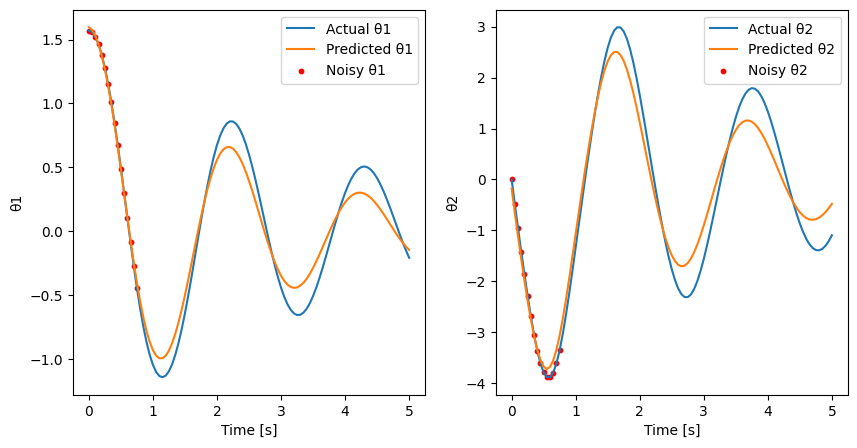

In [22]:
# Predict using the trained model
t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))
theta_pred = pinn(t_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, actual_theta[:, 0], label='Actual θ1')
plt.plot(t, theta_pred[:, 0], label='Predicted θ1')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], color='red', label='Noisy θ1', s=10)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('θ1')

plt.subplot(1, 2, 2)
plt.plot(t, actual_theta[:, 1], label='Actual θ2')
plt.plot(t, theta_pred[:, 1], label='Predicted θ2')
plt.scatter(t_train, actual_theta_noisy_train[:, 1], color='red', label='Noisy θ2', s=10)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('θ2')

plt.show()

## Physics Informed Machine Learning

In [5]:
# Model with beta_2 and beta_3
def model_discovery(theta, t, bm, beta_3):
    g = 9.81
    l = 1
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1) - beta_3 * theta1
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt

# Loss function
def loss_function(params, theta_0, t, actual_theta):
    bm, beta_3 = params
    predicted_theta = odeint(model_discovery, theta_0, t, args=(bm, beta_3,))
    return np.mean((predicted_theta[:,0] - actual_theta[:,0]) ** 2) # + np.mean((predicted_theta[:,1] - np.gradient(predicted_theta[:,0])) ** 2)

# Gradient function
def gradient(params, theta_0, t, actual_theta):
    eps = 1e-5
    grad = np.zeros_like(params)
    for i in range(len(params)):
        params_plus_eps = params.copy()
        params_plus_eps[i] += eps
        params_minus_eps = params.copy()
        params_minus_eps[i] -= eps
        grad[i] = (loss_function(params_plus_eps, theta_0, t, actual_theta) - 
                   loss_function(params_minus_eps, theta_0, t, actual_theta)) / (2 * eps)
    return grad

# Gradient descent function
def gradient_descent(theta_0, t, actual_theta, initial_params, learning_rate=0.01, max_iters=500000, tol=1e-7):
    params = initial_params.copy()
    for i in range(max_iters):
        grad = gradient(params, theta_0, t, actual_theta)
        params -= learning_rate * grad
        if np.linalg.norm(grad) < tol:
            print(f"Converged after {i+1} iterations.")
            break
    return params

In [10]:
# Initial parameters for gradient descent
initial_params = np.array([0.3, 0.8])

# Run gradient descent
estimated_params = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_params)
print("Estimated Parameters:", estimated_params)

# Function to simulate the system with estimated parameters
def simulate_system(theta_0, t, estimated_params):
    estimated_theta = odeint(model_discovery, theta_0, t, args=tuple(estimated_params))
    return estimated_theta

# Simulate the system with estimated parameters
estimated_theta = simulate_system(actual_theta_0, t, estimated_params)

# Calculate mean squared difference
squared_diff = np.square(actual_theta[:, 0] - estimated_theta[:, 0])
mean_squared_diff = np.mean(squared_diff)
print("Mean Squared Difference:", mean_squared_diff)

KeyboardInterrupt: 

In [11]:
beta_2_ml = []
beta_3_ml = []

noises = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for noise_sd in noises:
    # Actual theta values (assuming these are measured data)
    actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

    # Generate noise
    np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
    noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
    noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

    # Adding noise to the data
    actual_theta_noisy = np.copy(actual_theta)
    actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
    actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

    # Generate training dataset

    # Adjusting the time range
    t_max_new = 1.5  # Set the maximum time to 0.75 seconds
    t_train = np.arange(t_min, t_max_new + t_step, t_step)

    # Finding the index corresponding to the first second
    index_train = int(t_max_new / t_step) + 1

    # Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
    actual_theta_noisy_train = actual_theta_noisy[:index_train]

    # Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
    actual_theta_train = actual_theta[:index_train]

    # Initial parameters for gradient descent
    initial_params = np.array([0.3, 0.8])

    # Run gradient descent
    estimated_params = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_params)
    print("Estimated Parameters:", estimated_params)

    beta_2_ml.append(estimated_params[0])
    beta_3_ml.append(estimated_params[1])

beta_2_ml

Converged after 29212 iterations.
Estimated Parameters: [-5.34542040e-08  2.29090177e-06]
Converged after 28723 iterations.
Estimated Parameters: [-0.02276756  0.06222678]
Converged after 28236 iterations.
Estimated Parameters: [-0.04521052  0.12484435]
Converged after 27757 iterations.
Estimated Parameters: [-0.06733401  0.18785913]
Converged after 27269 iterations.
Estimated Parameters: [-0.08914385  0.25127323]
Converged after 26752 iterations.
Estimated Parameters: [-0.11064589  0.31508743]
Converged after 26208 iterations.
Estimated Parameters: [-0.13184629  0.37930191]


[-5.345420399227083e-08,
 -0.022767564787215214,
 -0.045210516919661874,
 -0.06733401381720697,
 -0.08914384710997918,
 -0.11064588974190631,
 -0.13184629498319375]

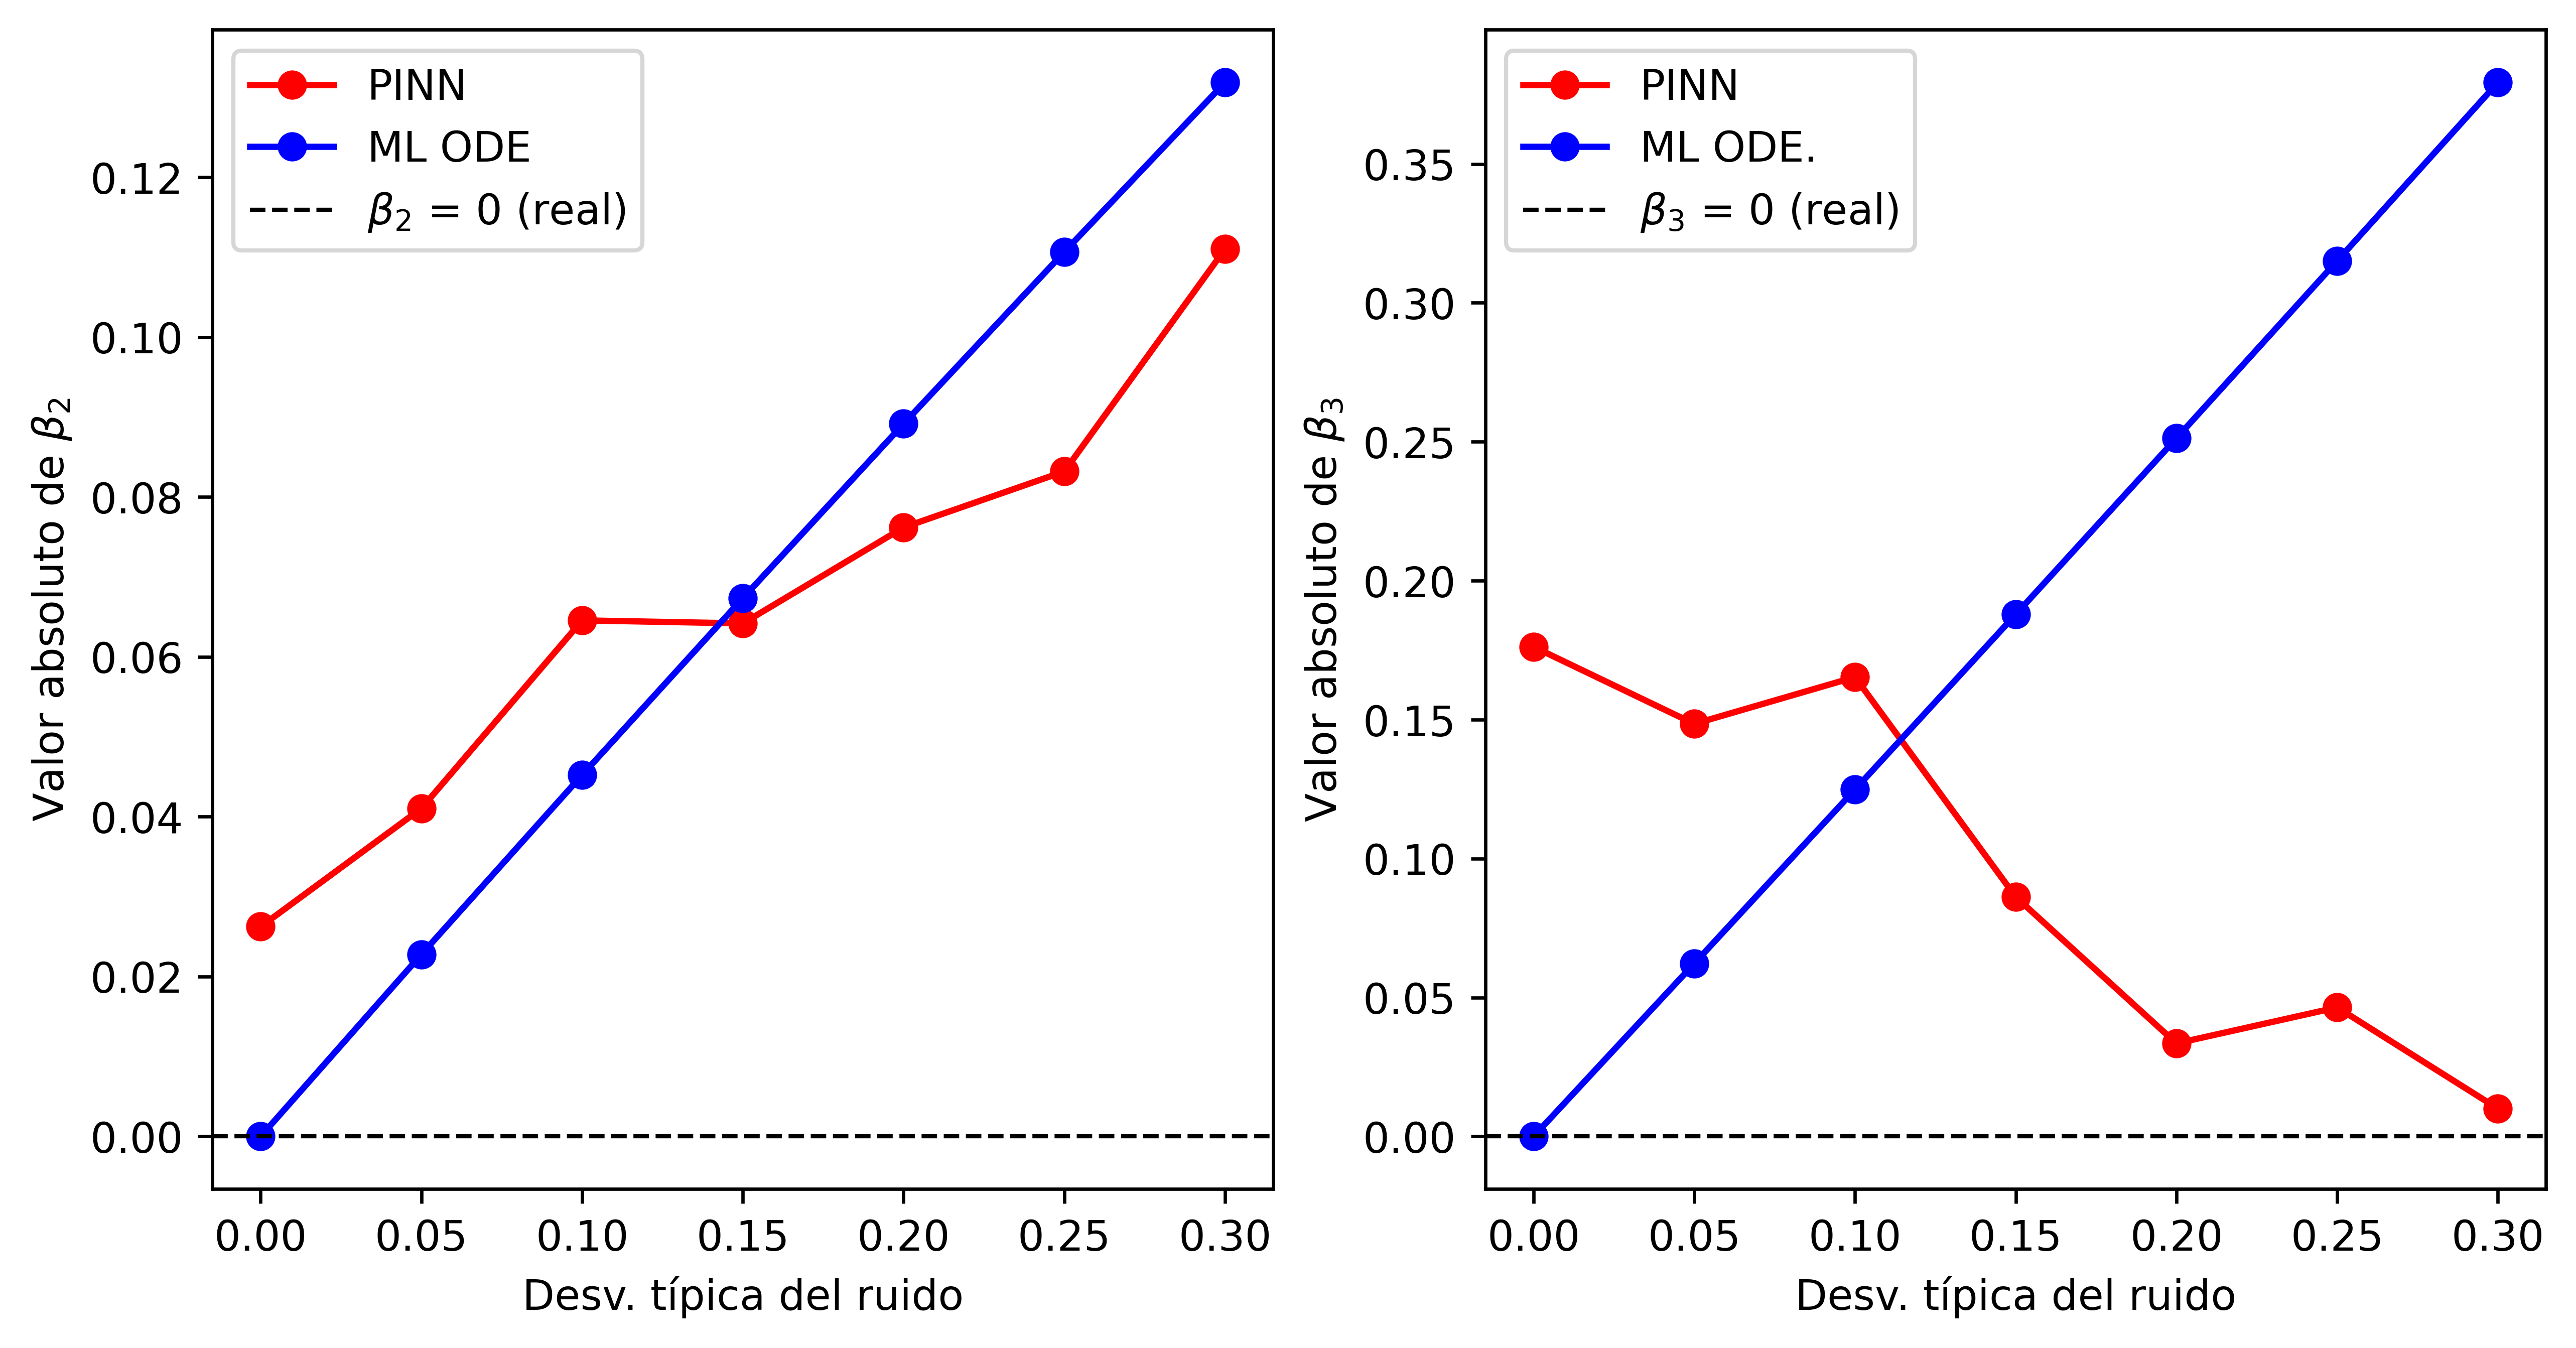

In [13]:
beta_2_pinn_abs = [abs(x) for x in beta_2_pinn]
beta_3_pinn_abs = [abs(x) for x in beta_3_pinn]
beta_2_ml_abs = [abs(x) for x in beta_2_ml]
beta_3_ml_abs = [abs(x) for x in beta_3_ml]

# Plot the results
plt.figure(figsize=(10, 5), dpi=600)
plt.subplot(1, 2, 1)
plt.plot(noises, beta_2_pinn_abs, color='red', label='PINN', marker='o')
plt.plot(noises, beta_2_ml_abs, color='blue', label='ML ODE', marker='o')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label=r'$\beta_2$ = 0 (real)')
plt.legend()
plt.xlabel('Desv. típica del ruido')
plt.ylabel(r'Valor absoluto de $\beta_2$')

plt.subplot(1, 2, 2)
plt.plot(noises, beta_3_pinn_abs, color='red', label='PINN', marker='o')
plt.plot(noises, beta_3_ml_abs, color='blue', label='ML ODE.', marker='o')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label=r'$\beta_3$ = 0 (real)')
plt.legend()
plt.xlabel('Desv. típica del ruido')
plt.ylabel(r'Valor absoluto de $\beta_3$')

plt.show()

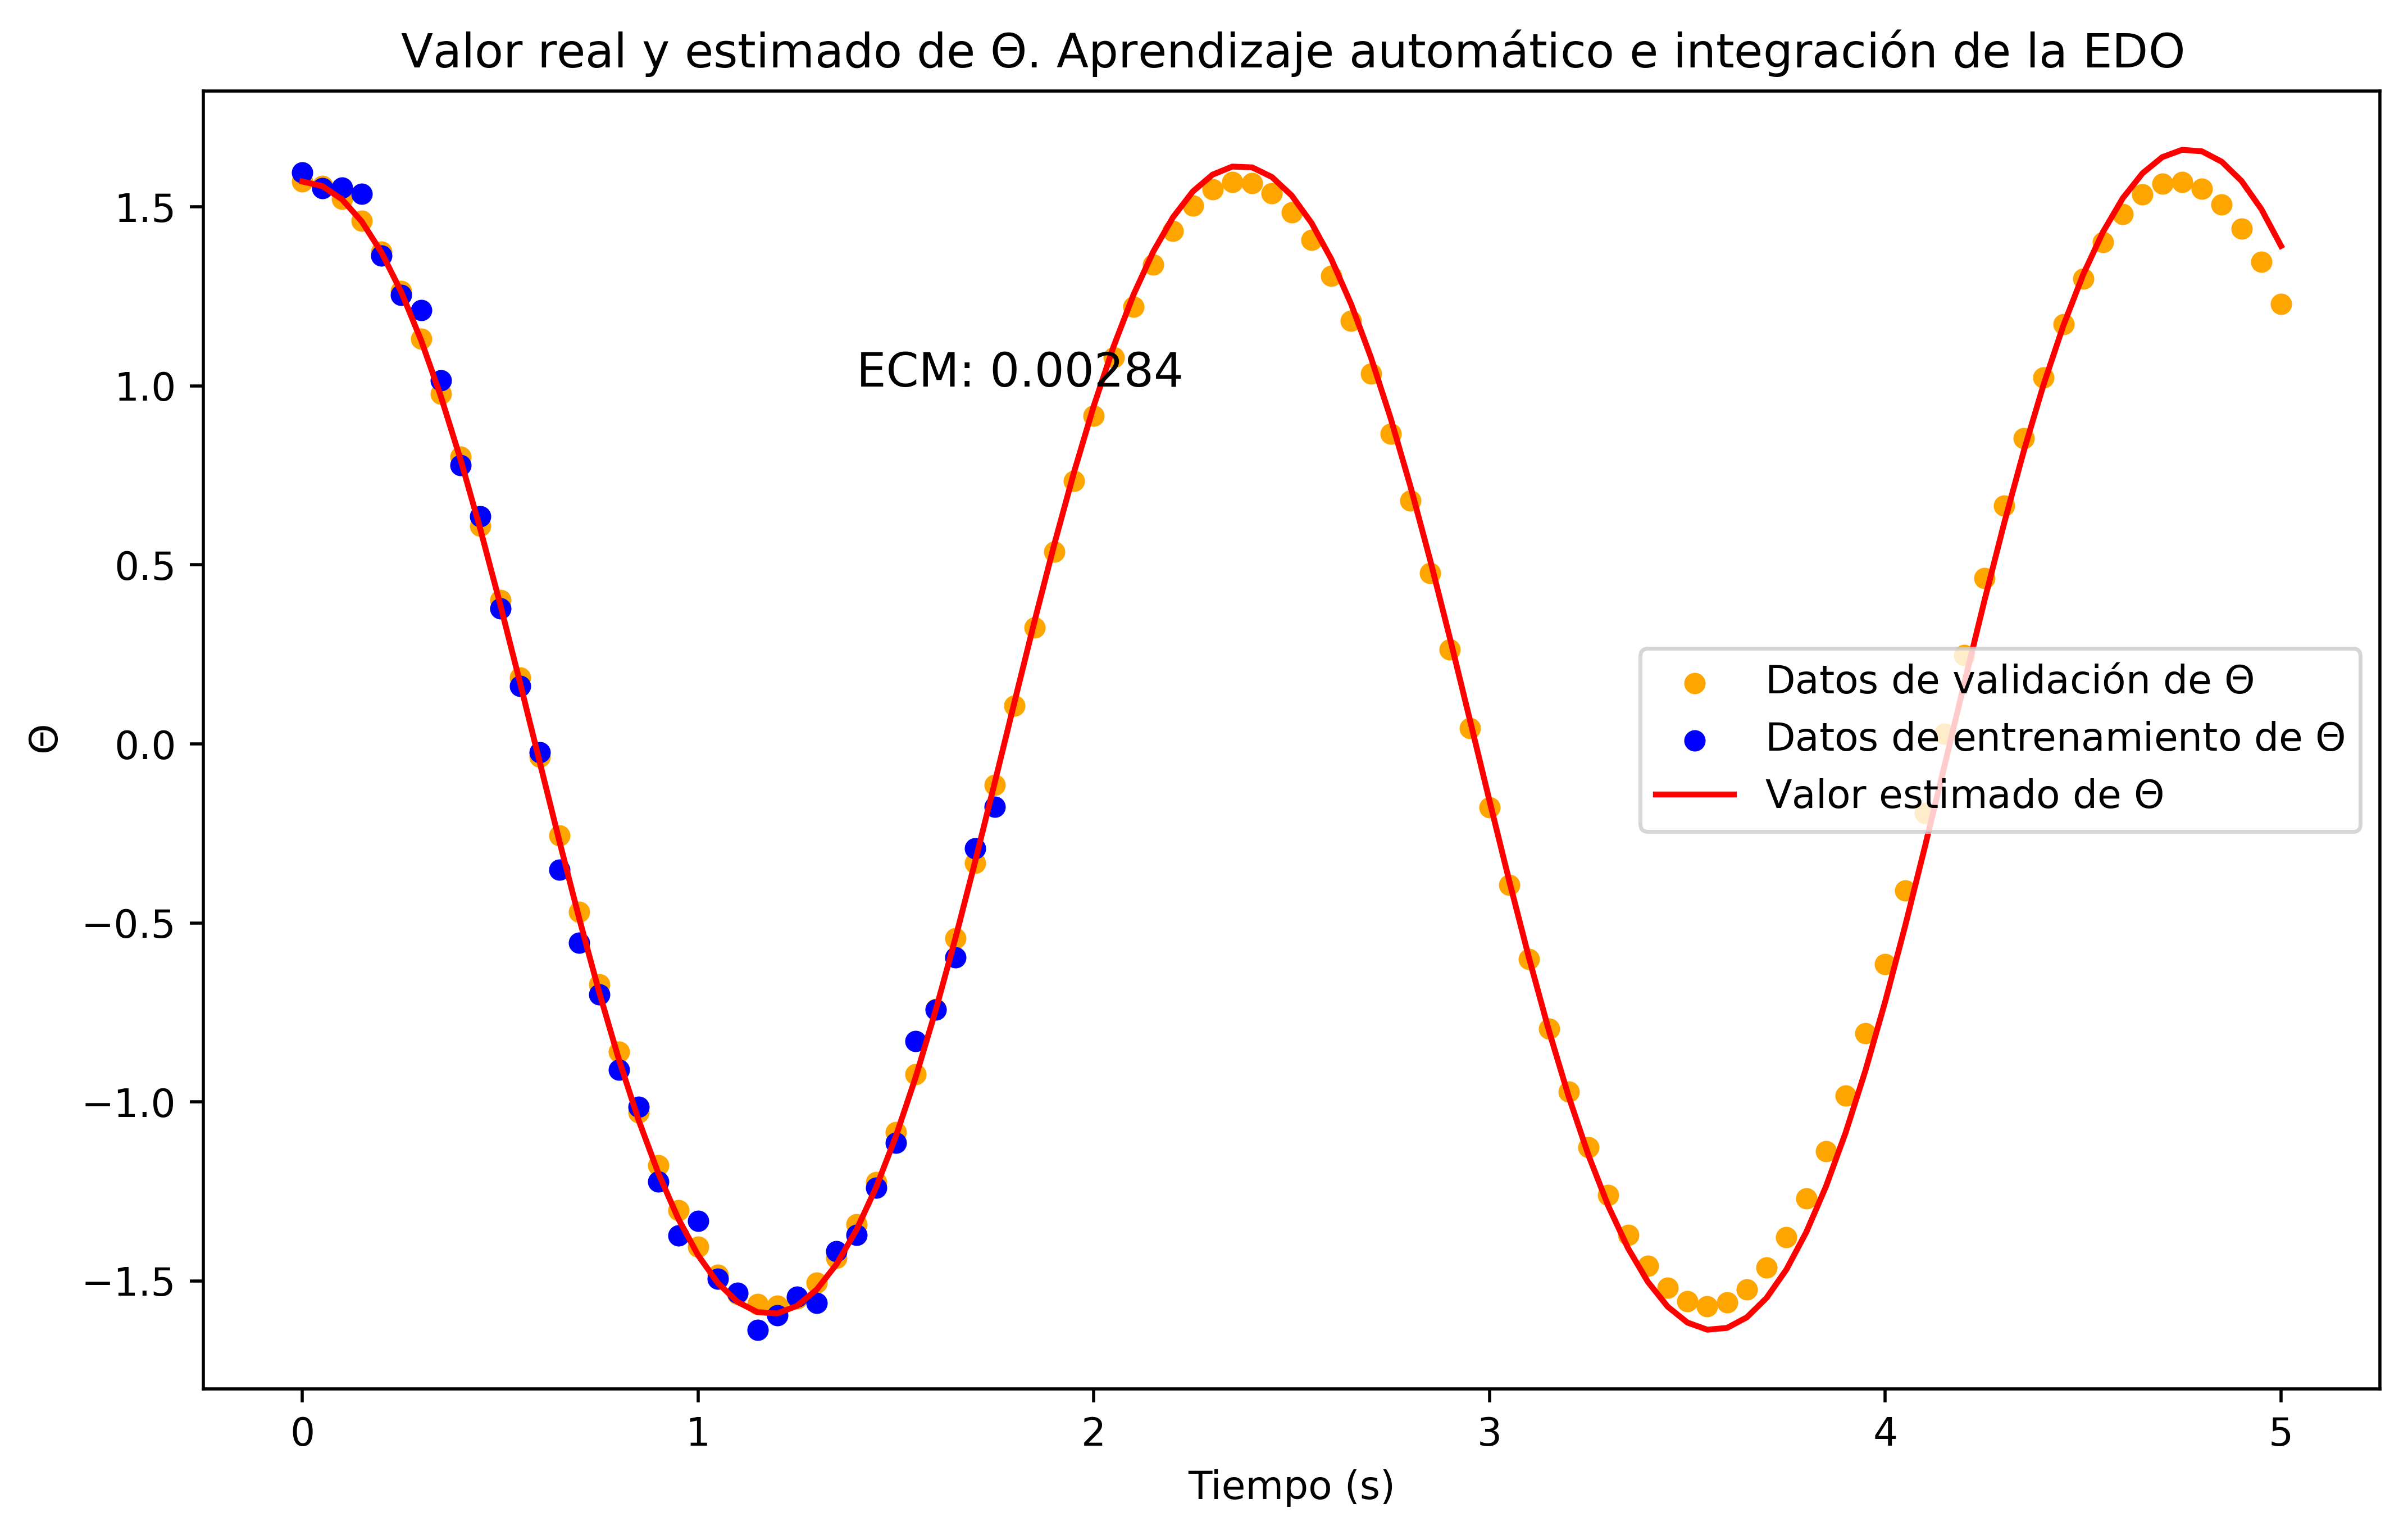

In [60]:
# Plotting
plt.figure(figsize=(10, 6), dpi = 500)
plt.scatter(t, actual_theta[:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, estimated_theta[:, 0], label=r'Valor estimado de $\Theta$', color='red')

# Annotate plot with mean squared difference
plt.text(0.3, 0.8, f'ECM: {mean_squared_diff:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title(r'Valor real y estimado de $\Theta$. Aprendizaje automático e integración de la EDO')
plt.xlabel('Tiempo (s)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.grid(False)
plt.show()